In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant, ArrayOutcome
import time

In [2]:
seeds = [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030]

In [3]:
# r, p, c, x_m,  additional_nodes=0, vis=False, o=24, random_data=False, load=1, seed=None

CPU times: total: 1.91 s
Wall time: 2.02 s


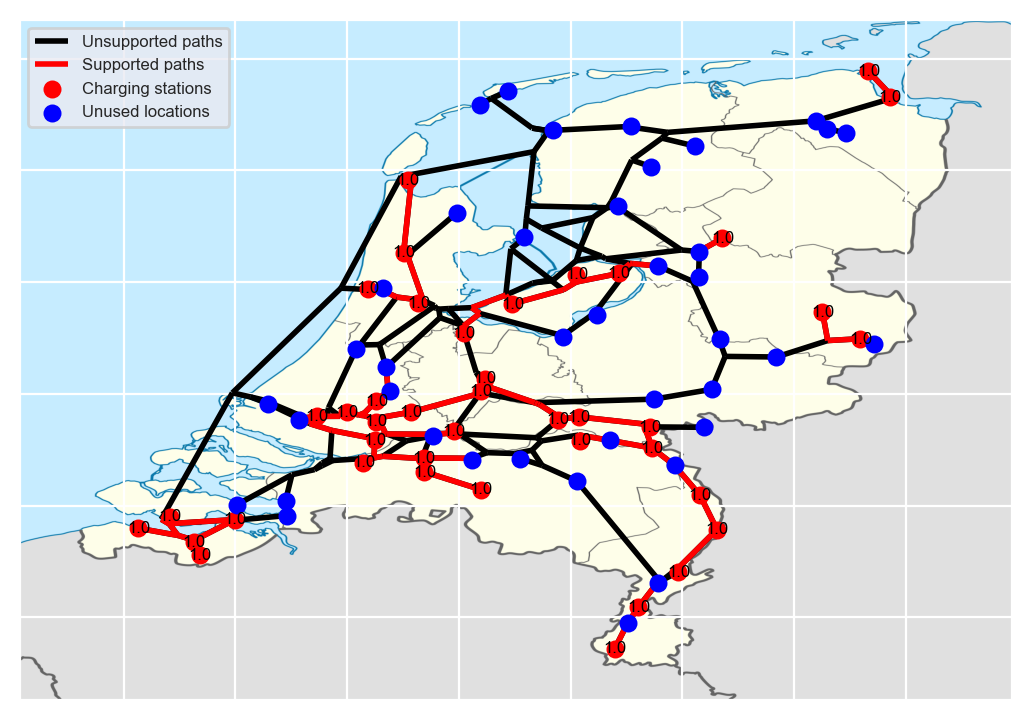

In [4]:
%%time
load=1
seed=seeds[0]
r=50000
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, add_nodes_used = flow_refueling_location_model(r,100, 2500, 5, additional_nodes=0, vis=True)

In [5]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [6]:
# inputs
# r, p, c, x_m,  additional_nodes=0, vis=False, o=24, random_data=False, load=1, seed=None

# outputs
# total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows

In [7]:
#define parameters
model.constants = [
    Constant('p', 40),
    Constant('c', 2500),
    Constant('x_m', 5),
    Constant("random_data", False),
]

model.uncertainties = [
    CategoricalParameter("r", [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000]),
#     CategoricalParameter("seed", [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030])
]

# set levers
model.levers = [
    CategoricalParameter("additional_nodes", [0, 1, 2, 3]),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ArrayOutcome('non_zero_flows'),
    ArrayOutcome("optimal_facilities"),
    ScalarOutcome('add_nodes_used'),
]

In [8]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=12) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=11, policies=4)

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\ema_workbench\em_framework\evaluators.py:349: UserWarning: the number of processes cannot be more then 20
  warnings.warn(
[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 11 scenarios * 4 policies * 1 model(s) = 44 experiments
100%|██████████████████████████████████████████| 44/44 [11:54<00:00, 16.24s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [11]:
# pickle.dump( experiments, open( "results/experiments_batch_run606new.p", "wb" ) )
# pickle.dump( outcomes, open("results/outcomes_batch_run606new.p", "wb") )

experiments = pickle.load(open("results/experiments_batch_run606new.p", "rb"))
outcomes = pickle.load(open("results/outcomes_batch_run606new.p", "rb"))

In [12]:
outcomes

{'total_flow': array([2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622, 2941841.19047622,
        2941841.19047622, 2941841.19047622]),
 'fraction_captured_total': array([0.10303663, 0.5919017 , 0.23853648, 0

In [13]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

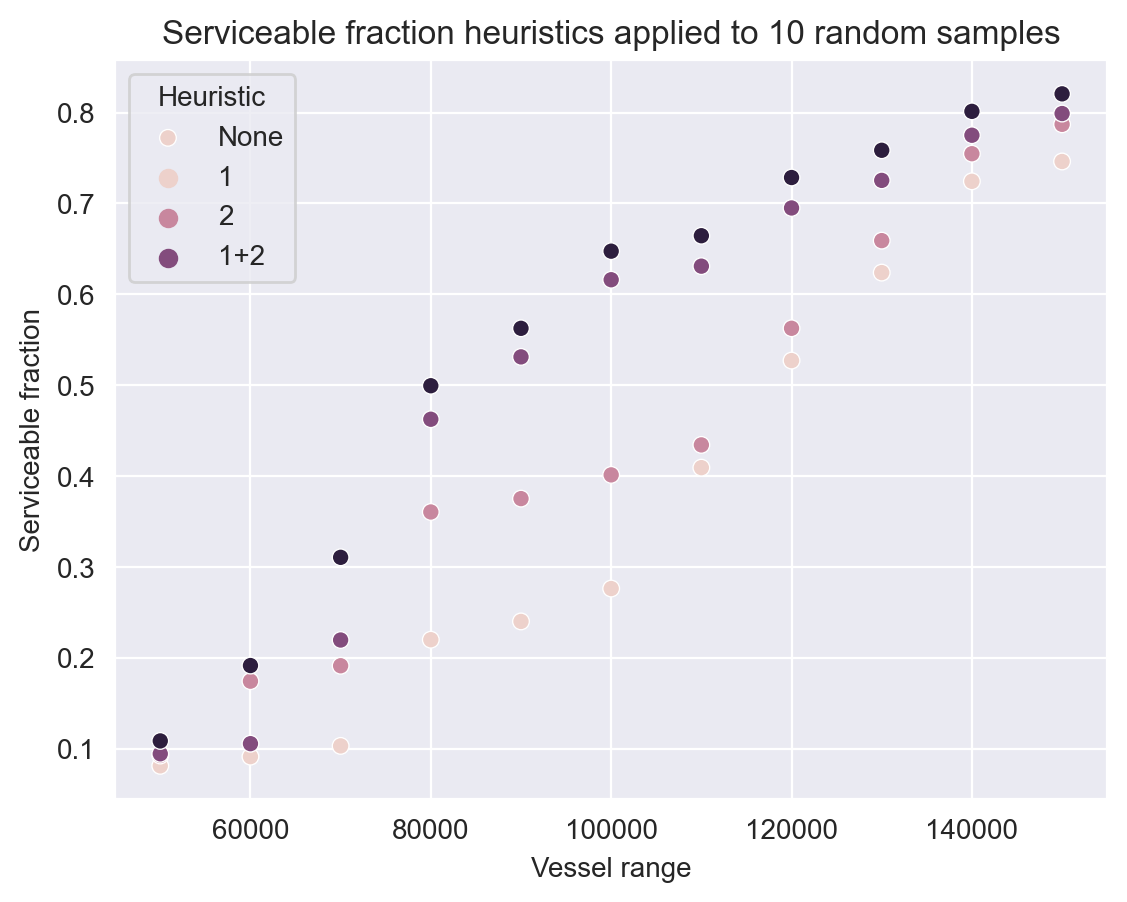

In [14]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='r', y='serviceable_fraction', hue='additional_nodes', data=df, ax=ax)
plt.title("Serviceable fraction heuristics applied to 10 random samples")
plt.ylabel("Serviceable fraction")
plt.xlabel("Vessel range")
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
plt.show()

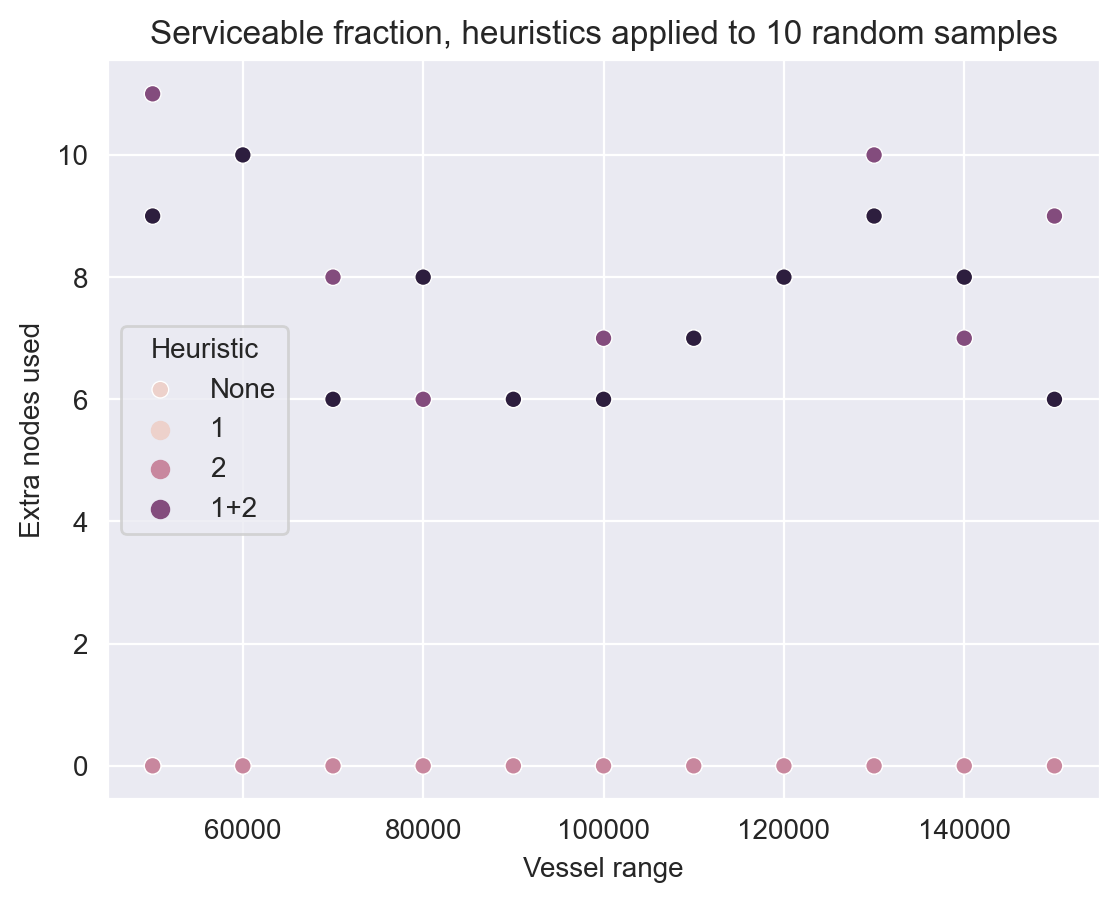

In [16]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='r', y='add_nodes_used', hue='additional_nodes', data=df, ax=ax)
plt.title("Serviceable fraction, heuristics applied to 10 random samples")
plt.ylabel("Extra nodes used")
plt.xlabel("Vessel range")
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
plt.show()

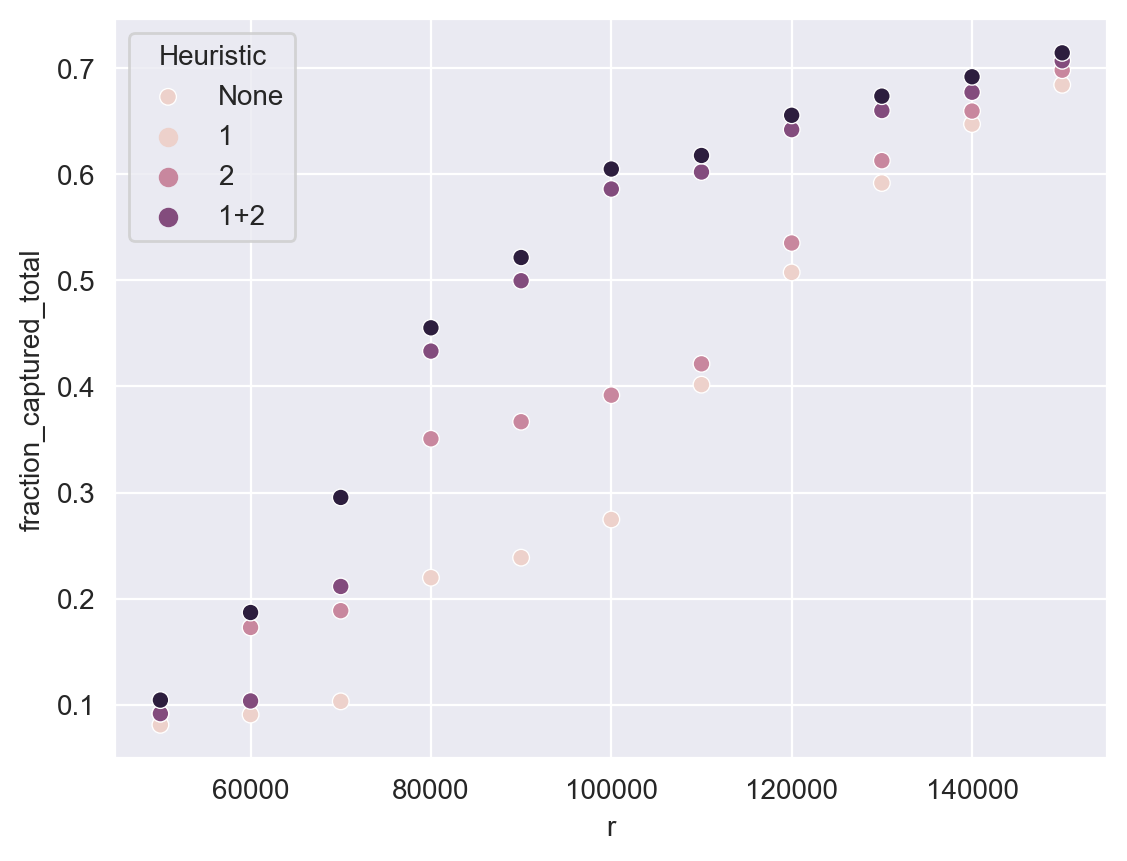

In [18]:
plt.subplots(dpi=200)
sns.scatterplot(x='r', y='fraction_captured_total', hue='additional_nodes', data=df)
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

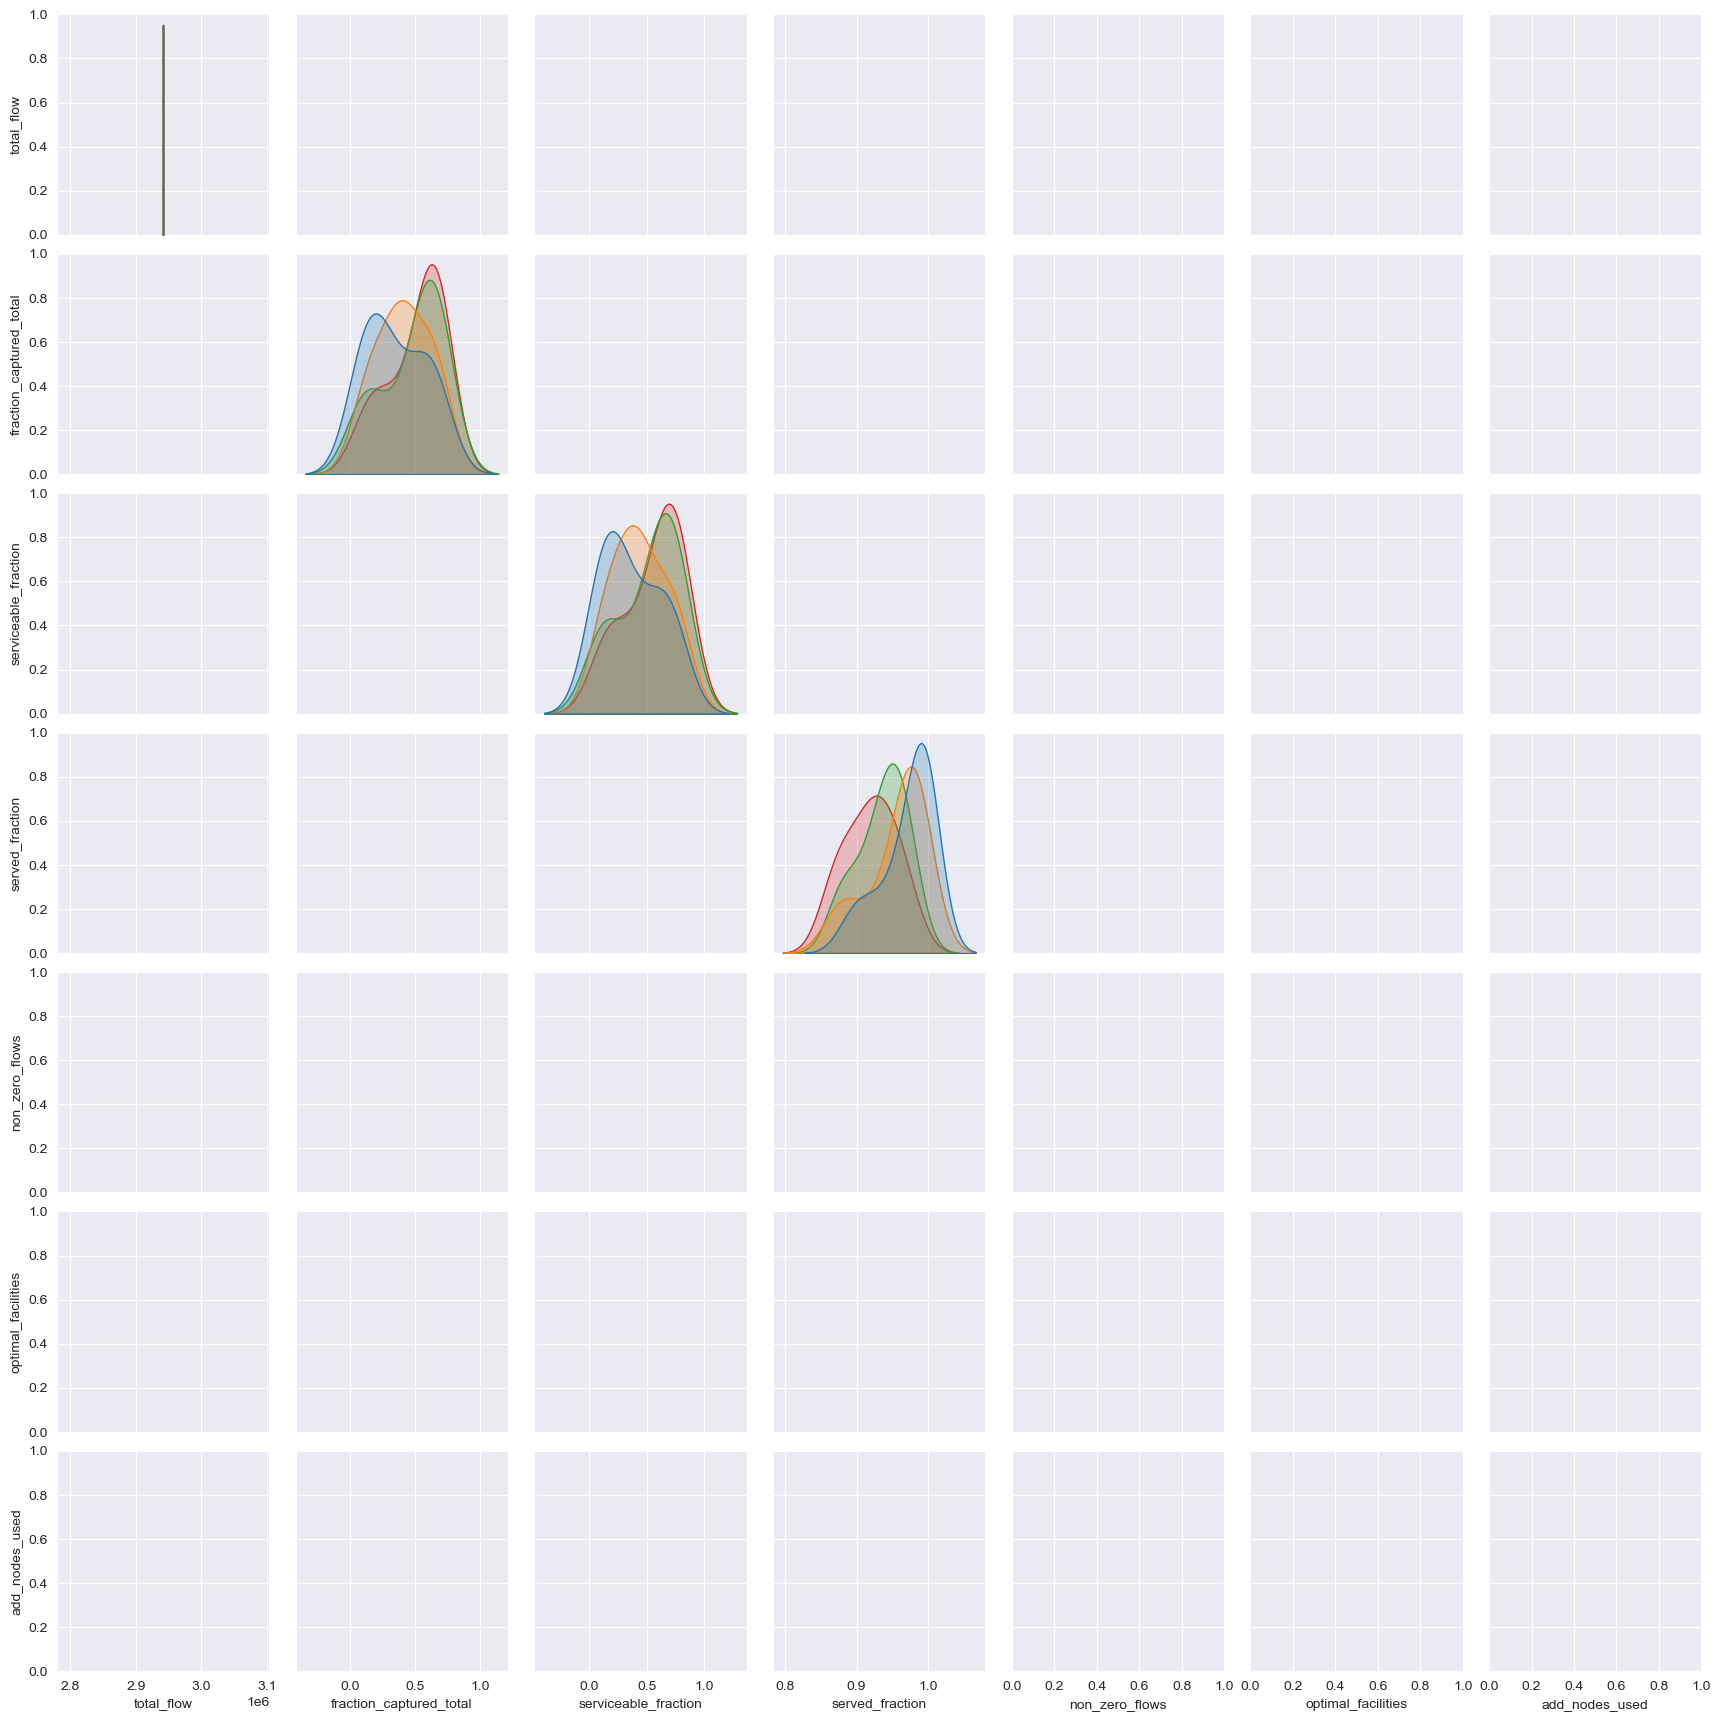

In [19]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

In [20]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


TypeError: float() argument must be a string or a real number, not 'dict'